## 1. Data preprocessing

### 1-1. Import libraries 

In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw

import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics

from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


import copy

### 1-2. Load data

In [72]:
# bitterdb: compound name, pubchem CID, smiles, bitterness label
bitterdb = pd.read_csv('../bitterness.csv')
bitterdb.drop(['Unnamed: 0'], axis=1, inplace=True)
bitterdb.head()

,Name,PubChem CID,CAS number,canonical SMILES,Taste,Class taste,Bitterness
0,(-)-3-Methoxy-4-hydroxyphenol 1-O-?-D-(6?-O-ga...,385552,*,COc1cc(ccc1O)OC1OC(COC(=O)c2cc(c(c(c2)O)O)O)C(...,Bitter,Bitterness,1
1,(-)-alpha-thujone,261491,546-80-5,CC(C)C12CC2C(C)C(=O)C1,Bitter,Bitterness,1
2,(-)-Epicatechin,72276,490-46-0,OC1Cc2c(cc(cc2OC1c1ccc(c(c1)O)O)O)O,Bitter,Bitterness,1
3,(-)-Epicatechin gallate,107905,1257-08-5,Oc1cc(c2c(c1)OC(C(C2)OC(=O)c1cc(c(c(c1)O)O)O)c...,Bitter,Bitterness,1
4,(-)-Epigallocatechin (EGC),72277,970-74-1,OC1Cc2c(cc(cc2OC1c1cc(c(c(c1)O)O)O)O)O,Bitter,Bitterness,1


In [54]:
# chemdb: chemical information of compounds that have 'Pubchem ID' in bitterdb 
chemdb = pd.read_excel('../Compound_chemical_info.xlsx')
chemdb.head()

,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,243,Benzoic Acid,benzoic acid|65-85-0|Dracylic acid|benzenecarb...,122.120,C7H6O2,37.3,104.0,1.9,9,1,...,182528,2D+3D,Benzoic Acid,Agrochemical Information|Biological Test Resul...,17,155|157|161|165|167|175|421|426|427|433|434|43...,20040916,001Chemical|1st Scientific|3B Scientific (Wuha...,Chemical Vendors|Curation Efforts|Governmental...,D000890 - Anti-Infective Agents > D000935 - An...
1,1176,Urea,urea|carbamide|57-13-6|Carbonyldiamide|Isourea...,60.056,CH4N2O,69.1,29.0,-1.4,4,2,...,7949,2D+3D,Urea,Agrochemical Information|Biological Test Resul...,17,200|330|421|426|427|433|434|435|445|530|540|54...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,B - Blood and blood forming organs > B05 - Blo...
2,1110,Succinic Acid,succinic acid|butanedioic acid|110-15-6|Amber ...,118.090,C4H6O4,74.6,92.6,-0.6,8,2,...,481,2D+3D,Succinic Acid,Agrochemical Information|Biological Test Resul...,17,155|157|161|165|167|175|192|194|248|256|270|32...,20040916,001Chemical|1st Scientific|3B Scientific (Wuha...,Chemical Vendors|Curation Efforts|Governmental...,COVID-19|COVID19|Coronavirus|Corona-virus|SARS...
3,2519,Caffeine,"caffeine|58-08-2|Guaranine|1,3,7-Trimethylxant...",194.190,C8H10N4O2,58.4,293.0,-0.1,14,0,...,36951,2D+3D,Caffeine,Agrochemical Information|Biological Test Resul...,17,155|157|161|165|167|175|192|248|256|316|328|35...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,C78272 - Agent Affecting Nervous System > C477...
4,5988,Sucrose,sucrose|57-50-1|saccharose|sugar|Table sugar|C...,342.300,C12H22O11,190.0,395.0,-3.7,23,8,...,215,2D+3D,Sucrose,Agrochemical Information|Biological Test Resul...,17,1189|1194|1199|1205|1469|1471|1479|1490|1688|1...,20040916,001Chemical|1st Scientific|3B Scientific (Wuha...,Chemical Vendors|Curation Efforts|Governmental...,D000074385 - Food Ingredients > D005503 - Food...


### 1-3. Data Preprocessing

In [16]:
# change the column name of 'Pubchem ID' to 'PubChem CID' to merge with bitterdb
chemdb.rename(columns={'cid': 'PubChem CID'}, inplace=True)
chemdb['PubChem CID'] = chemdb['PubChem CID'].astype(str)

# merge bitterdb and chemdb on 'Pubchem ID'
db = pd.merge(bitterdb, chemdb, how='left', on='PubChem CID')
db.head()

,Name,PubChem CID,CAS number,canonical SMILES,Taste,Class taste,Bitterness,cmpdname,cmpdsynonym,mw,...,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,(-)-3-Methoxy-4-hydroxyphenol 1-O-?-D-(6?-O-ga...,385552,*,COc1cc(ccc1O)OC1OC(COC(=O)c2cc(c(c(c2)O)O)O)C(...,Bitter,Bitterness,1,"[3,4,5-Trihydroxy-6-(4-hydroxy-3-methoxyphenox...",NSC676820|CHEMBL1994918|SCHEMBL15394763|NSC-67...,454.40,...,1.0,2D+3D,NaN,Biological Test Results|Classification|Patents,4.0,1|3|5|7|9|13|15|19|21|23|25|29|33|35|37|39|41|...,20050326.0,ABI Chem|ChemBank|ChEMBL|ChemDB|Cheminformatic...,Chemical Vendors|Curation Efforts|Governmental...,NaN
1,(-)-alpha-thujone,261491,546-80-5,CC(C)C12CC2C(C)C(=O)C1,Bitter,Bitterness,1,Thujone,alpha-Thujone|546-80-5|alpha-(-)-Thujone|(-)-a...,152.23,...,1671.0,2D+3D,NaN,Biological Test Results|Chemical and Physical ...,12.0,421|426|427|433|434|435|445|530|540|541|542|54...,20050326.0,001Chemical|3WAY PHARM INC|A2B Chem|AA BLOCKS|...,Chemical Vendors|Curation Efforts|Governmental...,NaN
2,(-)-Epicatechin,72276,490-46-0,OC1Cc2c(cc(cc2OC1c1ccc(c(c1)O)O)O)O,Bitter,Bitterness,1,Epicatechin,(-)-Epicatechin|Epicatechin|490-46-0|L-Epicate...,290.27,...,9555.0,2D+3D,Catechin,Biological Test Results|Chemical and Physical ...,14.0,357|377|410|411|444|445|446|447|448|450|451|52...,20050624.0,001Chemical|3B Scientific (Wuhan) Corp|A&J Pha...,Chemical Vendors|Curation Efforts|Governmental...,NaN
3,(-)-Epicatechin gallate,107905,1257-08-5,Oc1cc(c2c(c1)OC(C(C2)OC(=O)c1cc(c(c(c1)O)O)O)c...,Bitter,Bitterness,1,(-)-Epicatechin gallate,(-)-Epicatechin gallate|1257-08-5|Epicatechin ...,442.40,...,217.0,2D+3D,NaN,Biological Test Results|Chemical and Physical ...,13.0,608|940|1033|1422|1549|1552|1637|1648|78764|78...,20050801.0,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,D000970 - Antineoplastic Agents|D004791 - Enzy...
4,(-)-Epigallocatechin (EGC),72277,970-74-1,OC1Cc2c(cc(cc2OC1c1cc(c(c(c1)O)O)O)O)O,Bitter,Bitterness,1,Epigallocatechin,(-)-Epigallocatechin|Epigallocatechin|970-74-1...,306.27,...,8131.0,2D+3D,NaN,Biological Test Results|Chemical and Physical ...,11.0,1|3|5|7|9|13|15|19|21|23|25|29|33|35|37|39|41|...,20050326.0,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN


In [17]:
# change the name of columns
db.rename(columns={'cmpdsynonym': 'Name_synonym', 'hbonddonor':'HDB', 'hbondacc':'HDA', 'mw': 'MW'}, inplace=True)
db['RING'] = 0

# extract the columns that we need
db = db[['Name', 'Name_synonym', 'PubChem CID', 'CAS number', 'canonical SMILES', 'Taste', 'Class taste', 'MW', 'xlogp', 'HDB', 'HDA', 'RING', 'Bitterness']]
db.head()

,Name,Name_synonym,PubChem CID,CAS number,canonical SMILES,Taste,Class taste,MW,xlogp,HDB,HDA,RING,Bitterness
0,(-)-3-Methoxy-4-hydroxyphenol 1-O-?-D-(6?-O-ga...,NSC676820|CHEMBL1994918|SCHEMBL15394763|NSC-67...,385552,*,COc1cc(ccc1O)OC1OC(COC(=O)c2cc(c(c(c2)O)O)O)C(...,Bitter,Bitterness,454.40,0.0,7.0,12.0,0,1
1,(-)-alpha-thujone,alpha-Thujone|546-80-5|alpha-(-)-Thujone|(-)-a...,261491,546-80-5,CC(C)C12CC2C(C)C(=O)C1,Bitter,Bitterness,152.23,2.3,0.0,1.0,0,1
2,(-)-Epicatechin,(-)-Epicatechin|Epicatechin|490-46-0|L-Epicate...,72276,490-46-0,OC1Cc2c(cc(cc2OC1c1ccc(c(c1)O)O)O)O,Bitter,Bitterness,290.27,0.4,5.0,6.0,0,1
3,(-)-Epicatechin gallate,(-)-Epicatechin gallate|1257-08-5|Epicatechin ...,107905,1257-08-5,Oc1cc(c2c(c1)OC(C(C2)OC(=O)c1cc(c(c(c1)O)O)O)c...,Bitter,Bitterness,442.40,1.5,7.0,10.0,0,1
4,(-)-Epigallocatechin (EGC),(-)-Epigallocatechin|Epigallocatechin|970-74-1...,72277,970-74-1,OC1Cc2c(cc(cc2OC1c1cc(c(c(c1)O)O)O)O)O,Bitter,Bitterness,306.27,0.0,6.0,7.0,0,1


In [18]:
# check the number of null values
db.isnull().sum()

Name                   0
Name_synonym        1107
PubChem CID            0
CAS number             0
canonical SMILES       0
Taste                  0
Class taste            0
MW                   898
xlogp               1199
HDB                  898
HDA                  898
RING                   0
Bitterness             0
dtype: int64

In [19]:
# make a list of canonical SMILES that have null values in MW
# we will fill out this null values using rdkit
nan_list = list(db[db['MW'].isnull()]['canonical SMILES'].values)
nan_list[:10]

xlogp_nan_list = list(db[db['xlogp'].isnull()]['canonical SMILES'].values)
xlogp_nan_list[:10]

['COc1cc(cc(c1O)OC)C1C(COC2OC(COC(=O)c3cc(c(c(c3)O)O)O)C(O)C(O)C2O)C(CO)Cc2cc(c(c(c12)OC)O)OC',
 'COc1cc(cc(c1O)OC)C1C(COC2OC(COC(=O)c3cc(c(c(c3)O)O)O)C(O)C(O)C2O)C(CO)Cc2cc(c(c(c12)OC)O)OC',
 'COc1cc2c(cc1OC)C1c3ccc(c(c3OCC1(O)C2)OC)OC',
 'CC(CCC1(O)OC2CC3C4CCC5CC(CCC5(C)C4CCC3(C)C2C1C)OC1OC(CO)C(OC2OC(C)C(O)C(O)C2O)C(O)C1O)COC1OC(CO)C(O)C(O)C1O',
 'CC1C2CC(OC(C)=O)C(=C)C(O)CCC(=CC2OC1=O)C',
 'CCCC(CCCOC)CCc1ccccc1',
 'CC1=CCC2(O)C1C(O)C(C(O)C=C2C)C(=C)C(O)=O',
 'CN(C)C(=N)N=C(N)N.OC(=O)CC(O)(CC(O)=O)C(O)=O',
 'OCC1C(=CC2=CC=CO2)C(=O)c2cc(c(c[n+]12)[O-])CC1=CC=CO1',
 'COCC(O)CC(C)CCc1ccccc1']

In [20]:
# fill out the null values in MW, xlogp, HDB, HDA using rdkit
for i in range(len(db)):
    if db['canonical SMILES'][i] in nan_list:
        db['MW'][i] = Chem.Descriptors.MolWt(Chem.MolFromSmiles(db['canonical SMILES'][i]))             # MW
        db['xlogp'][i] = Chem.Descriptors.MolLogP(Chem.MolFromSmiles(db['canonical SMILES'][i]))        # xlogp
        db['HDB'][i] = Chem.Descriptors.NumHDonors(Chem.MolFromSmiles(db['canonical SMILES'][i]))       # HDB
        db['HDA'][i] = Chem.Descriptors.NumHAcceptors(Chem.MolFromSmiles(db['canonical SMILES'][i]))    # HDA
    if db['canonical SMILES'][i] in xlogp_nan_list:
        db['xlogp'][i] = Chem.Descriptors.MolLogP(Chem.MolFromSmiles(db['canonical SMILES'][i]))        # xlogp
    db['RING'][i] = Chem.Descriptors.RingCount(Chem.MolFromSmiles(db['canonical SMILES'][i]))           # RING
db

/tmp/ipykernel_3794091/712409445.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['RING'][i] = Chem.Descriptors.RingCount(Chem.MolFromSmiles(db['canonical SMILES'][i]))           # RING
/tmp/ipykernel_3794091/712409445.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db['xlogp'][i] = Chem.Descriptors.MolLogP(Chem.MolFromSmiles(db['canonical SMILES'][i]))        # xlogp
/tmp/ipykernel_3794091/712409445.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

,Name,Name_synonym,PubChem CID,CAS number,canonical SMILES,Taste,Class taste,MW,xlogp,HDB,HDA,RING,Bitterness
0,(-)-3-Methoxy-4-hydroxyphenol 1-O-?-D-(6?-O-ga...,NSC676820|CHEMBL1994918|SCHEMBL15394763|NSC-67...,385552,*,COc1cc(ccc1O)OC1OC(COC(=O)c2cc(c(c(c2)O)O)O)C(...,Bitter,Bitterness,454.400,0.0000,7.0,12.0,3,1
1,(-)-alpha-thujone,alpha-Thujone|546-80-5|alpha-(-)-Thujone|(-)-a...,261491,546-80-5,CC(C)C12CC2C(C)C(=O)C1,Bitter,Bitterness,152.230,2.3000,0.0,1.0,2,1
2,(-)-Epicatechin,(-)-Epicatechin|Epicatechin|490-46-0|L-Epicate...,72276,490-46-0,OC1Cc2c(cc(cc2OC1c1ccc(c(c1)O)O)O)O,Bitter,Bitterness,290.270,0.4000,5.0,6.0,3,1
3,(-)-Epicatechin gallate,(-)-Epicatechin gallate|1257-08-5|Epicatechin ...,107905,1257-08-5,Oc1cc(c2c(c1)OC(C(C2)OC(=O)c1cc(c(c(c1)O)O)O)c...,Bitter,Bitterness,442.400,1.5000,7.0,10.0,4,1
4,(-)-Epigallocatechin (EGC),(-)-Epigallocatechin|Epigallocatechin|970-74-1...,72277,970-74-1,OC1Cc2c(cc(cc2OC1c1cc(c(c(c1)O)O)O)O)O,Bitter,Bitterness,306.270,0.0000,6.0,7.0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,Trichodonin,NaN,101289758,*,CC(=O)OCC12C(CCC(C)(C)C1C=O)OC(=O)C13CC(CC(O)C...,Tasteless,Tastelessness,404.459,1.6088,1.0,7.0,4,0
2507,Trichokaurin,"Trichokaurin|23811-50-9|[(1R,2R,5R,7R,8R,9S,10...",91884741,23811-50-9,CC(=O)OC1C2C(C)(C)CCC(O)C32COC1(O)C12CC(CCC31)...,Tasteless,Tastelessness,434.500,1.9000,2.0,7.0,6,0
2508,β-(3-amino-4-methoxyphenyl) ethylbenzene,NaN,*,*,COc1ccc(cc1N)CCc1ccccc1,Tasteless,Tastelessness,227.307,3.0626,1.0,2.0,2,0
2509,β-(4-hydroxy-3-methoxyphenyl) ethylbenzene,3-methoxy-4-hydroxybibenzyl|SCHEMBL16355871,10059663,*,COc1cc(ccc1O)CCc1ccccc1,Tasteless,Tastelessness,228.290,3.1000,1.0,2.0,2,0


In [21]:
db.isnull().sum()

Name                   0
Name_synonym        1107
PubChem CID            0
CAS number             0
canonical SMILES       0
Taste                  0
Class taste            0
MW                     0
xlogp                  0
HDB                    0
HDA                    0
RING                   0
Bitterness             0
dtype: int64

In [22]:
db.to_csv('bitterness_notnull.csv')

### 1-4. Data visualization

([<matplotlib.axis.XTick at 0x7ff99b8f1490>,
 [Text(0, 0, 'non-bitter'), Text(1, 0, 'bitter')])

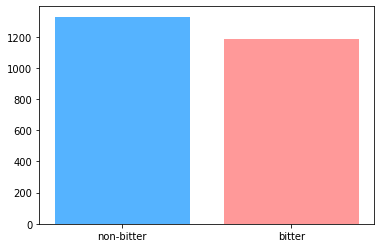

In [23]:
plt.bar(db['Bitterness'].value_counts().index, db['Bitterness'].value_counts().values, color=['#55b3ff', '#ff9999'])
plt.xticks([0, 1], ['non-bitter', 'bitter'])

([<matplotlib.axis.XTick at 0x7ff999889580>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

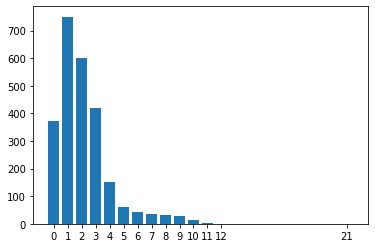

In [24]:
plt.bar(db['RING'].value_counts().index, db['RING'].value_counts().values)
plt.xticks(db['RING'].value_counts().index)

In [25]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2511 entries, 0 to 2510
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              2511 non-null   object 
 1   Name_synonym      1404 non-null   object 
 2   PubChem CID       2511 non-null   object 
 3   CAS number        2511 non-null   object 
 4   canonical SMILES  2511 non-null   object 
 5   Taste             2511 non-null   object 
 6   Class taste       2511 non-null   object 
 7   MW                2511 non-null   float64
 8   xlogp             2511 non-null   float64
 9   HDB               2511 non-null   float64
 10  HDA               2511 non-null   float64
 11  RING              2511 non-null   int64  
 12  Bitterness        2511 non-null   int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 339.2+ KB


## 2. Make datasets and Model Training

### 2-1. Make datasets

In [27]:
df = pd.DataFrame(db[['MW', 'xlogp', 'HDB', 'HDA', 'RING', 'Bitterness']])
print(df.shape)
df.head()

(2511, 6)


,MW,xlogp,HDB,HDA,RING,Bitterness
0,454.40,0.0,7.0,12.0,3,1
1,152.23,2.3,0.0,1.0,2,1
2,290.27,0.4,5.0,6.0,3,1
3,442.40,1.5,7.0,10.0,4,1
4,306.27,0.0,6.0,7.0,3,1


In [28]:
train, test = train_test_split(df, test_size=0.2)

In [29]:
class CustomDataset(Dataset):
    def __init__(self, data, target='Bitterness', normalize=True):
        super(CustomDataset, self).__init__()
        self.x = data.drop(target, axis=1)
        
        if normalize:
            scaler = StandardScaler()
            self.x = pd.DataFrame(scaler.fit_transform(self.x), columns=self.x.columns)
        
        self.y = data[target]
        
        self.x = torch.tensor(self.x.values).float()
        self.y = torch.tensor(self.y.values).float()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        
        return x, y

In [30]:
train_dataset = CustomDataset(train)
test_dataset = CustomDataset(test)

In [31]:
BATCH_SIZE = 32
NUM_FEATURES = len(df.drop('Bitterness', axis=1).columns)
EPOCH = 300
LR = 0.001

In [32]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [33]:
train_x, train_y = next(iter(train_loader))
train_x.shape, train_y.shape

(torch.Size([32, 5]), torch.Size([32]))

In [34]:
test_x, test_y = next(iter(test_loader))
test_x.shape, test_y.shape

(torch.Size([32, 5]), torch.Size([32]))

### 2-2. Build a model

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [36]:
class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(num_features, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        
        return y

In [37]:
model = Net(NUM_FEATURES).to(device)
model

Net(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=1, bias=True)
)

### 2-3. Model training

In [38]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [39]:
losses = []
acces = []
best_loss = 1000000
patience_counter = 0
patience_limit = 7
accuracy = torchmetrics.Accuracy(num_classes=2)

for epoch in range(EPOCH):
    running_loss = 0
    running_acc = 0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_func(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        for i in range(len(y_pred)):
            if y_pred[i] >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
        
            if y_pred[i] == y[i]:
                running_acc += 1
        
    loss = running_loss / len(train_loader)
    acc = running_acc / len(y_pred)
    losses.append(loss)
    acces.append(acc)
    
    model.eval()
    val_loss = 0
    
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = loss_func(y_pred, y.unsqueeze(1))
        
        val_loss += loss.item()
    if val_loss > best_loss:
        patience_counter +=1
        if patience_counter >= patience_limit:
            print('Early Stopping')
            break
    else:
        best_loss = val_loss
        patience_counter = 0
        
        
    if epoch % 10 == 0:
        print(f"epoch: {epoch}, train_loss: {round(losses[-1], 3)}, train_acc: {round(acces[-1], 3)}, val_loss: {round(val_loss/len(test_loader), 3)}")

print('Finished Training')
# print(f"epoch: {} train_loss = {losses[-1]}, val_loss = {1:.5f}".format(epoch, losses[-1], val_loss/len(test_loader)))
print(f'epoch: {epoch}, train_loss: {losses[-1]}, val_loss: {val_loss/len(test_loader)}')

epoch: 0, train_loss: 0.511, train_acc: 44.417, val_loss: 0.371
epoch: 10, train_loss: 0.203, train_acc: 56.583, val_loss: 0.193
epoch: 20, train_loss: 0.187, train_acc: 60.25, val_loss: 0.179
epoch: 30, train_loss: 0.176, train_acc: 63.125, val_loss: 0.167
epoch: 40, train_loss: 0.17, train_acc: 63.833, val_loss: 0.161
epoch: 50, train_loss: 0.166, train_acc: 64.75, val_loss: 0.16
epoch: 60, train_loss: 0.164, train_acc: 64.875, val_loss: 0.154
epoch: 70, train_loss: 0.161, train_acc: 65.042, val_loss: 0.152
epoch: 80, train_loss: 0.16, train_acc: 64.75, val_loss: 0.15
Early Stopping
Finished Training
epoch: 85, train_loss: 0.1588457248040608, val_loss: 0.15025637950748205


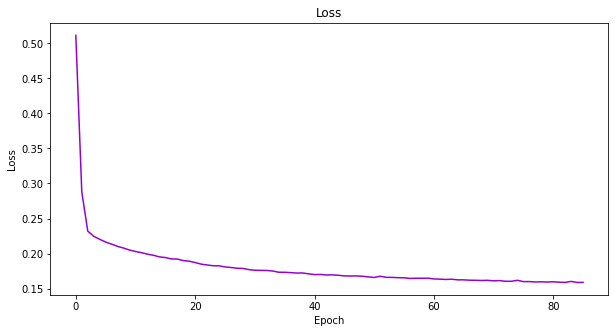

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(losses, c='darkviolet')

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()